Scraping newspaper articles from derstandard.at
===

* relating to
    * Croatia
    * Serbia
    * Hungary (control I)
    * Slowakia (control II)
* direct search (no intermediate search step via twitter)

I focus on articles from derstandard, because it's among the most popular online newspapers in Austria and because building a scraper for a specific newspaper and scraping itself is a tedious and time-consuming task. This should serve as a proof-of-concept and can later be adapted to include a larger set of Austrian newspapers.

In [1]:
import jupyter_black

jupyter_black.load()

## Imports and functions

In [73]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.options import Options
from time import sleep
import squarify


data_dir = "data/derstandard"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def get_derstandard_article(url):
    """

    Scrapes article from derstandard.at
    and returns title, subtitle and
    complete article text

    """

    options = Options()
    options.add_argument("-headless")

    driver = webdriver.Firefox(options=options)

    driver.set_script_timeout(30)
    try:
        driver.get(url)

    except:
        driver.quit()
        print("Could not process url:", url)
        return "", "", ""

    # switch to iframe (when it is avilable) with button and click it
    iframes = driver.find_elements(By.TAG_NAME, "iframe")

    # wait for both iframes to appear
    while len(iframes) < 2:
        iframes = driver.find_elements(By.TAG_NAME, "iframe")

    iframe = iframes[1]
    WebDriverWait(driver, 20).until(EC.frame_to_be_available_and_switch_to_it(iframe))
    WebDriverWait(driver, 20).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
    ).click()

    # switch to new window
    new_window = driver.window_handles
    driver.switch_to.window(new_window[0])

    sleep(2)

    if url[:45] == "https://www.derstandard.at/jetzt/livebericht/":
        article_title = driver.find_element(By.ID, "content-header").text
        article_subtitle = ""
        article_text = driver.find_element(By.ID, "content-main").text
        article_date = driver.find_element(By.CLASS_NAME, "date").text

    else:
        article_title = driver.find_element(By.CLASS_NAME, "article-title").text
        article_subtitle = driver.find_element(
            By.CLASS_NAME, "article-subtitle"
        ).text
        article_body = driver.find_element(By.CLASS_NAME, "article-body")
        article_text = article_body.text
        article_date = driver.find_element(By.TAG_NAME, "time").text

    # translate German to English dates
    d = {
        "Jänner": "Jan",
        "Januar": "Jan",
        "Feber": "Feb",
        "Februar": "Feb",
        "März": "Mar",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Oktober": "Oct",
        "Dezember": "Dec",
    }

    article_date = " ".join(d.get(ele, ele) for ele in article_date.split())
    article_date = pd.Timestamp(article_date).isoformat()

    driver.quit()

    return article_title, article_subtitle, article_text, article_date

## Search

### Search words for countries

In [74]:
countries_min = dict(
    serbia="serbien",
    croatia="kroatien",
    slovakia="slowakei",
    hungary="ungarn",
    albania="albanien",
    austria="österreich",
    bosnia="bosnien",
    montenegro="montenegro",
    spain="spanien",
    slovenia="slowenien",
    kosovo="kosovo",
    northmacedonia="mazedonien",
    bulgaria="bulgarien",
    romania="rumänien",
    yugoslavia="jugoslawien",
)

### Define countries of interest

Articles that include Serbia or Yugoslavia (until 2003), but do not include Croatia will be later treated as "Serbia", Articles that include Croatia, but not Serbia or Yugoslavia (until 2003) will be later treated as "Croatia". The reason for this is that "Yugoslavia" was the name for the country later called Serbia (Serbia & Montenegro). To make this visible, I will re-label Yugoslavia-articles between 1998 and 2003 from "jugoslawien" to "serbien".  It's difficult to know whether an article referes to old Yugoslavia before the war or to the country later called Serbia (& Montenegro), but I assume that between 1998 and 2003 the articles refere to the latter. I could be wrong, of course, but excluding these articles could make things worse.

In [75]:
cois = [
    "serbia",
    "yugoslavia",
    "croatia",
    "slovenia",
    "northmacedonia",
    "bosnia",
    "montenegro",
    "kosovo",
    "slovakia",
    "hungary",
    "albania",
]

### Retrieve urls of relevant articles and store them in textfiles

The news archive dates back to 1997, the articles found on the subject are from 1998&ndash;2023. The breakup of Yugoslavia started in 1991, followed by the war in Croatia in the same year and the war in Bosnia in 1992. Armed conflict ended in 1995. In 1998, when the first newspaper articles are available, the war in Kosovo started and lasted until 1999, when NATO started bombing Serbia (back then "Yugoslavia") between March and June.

In [ ]:
if os.path.exists(data_dir+"/urls") == False:
    os.makedirs(data_dir+"/urls")

    
# iterate over countries
for coi in cois:

    country = countries_min[coi]

    # iterate over years
    for year in range(1997, 2023 + 1):

        page = 0

        # iterate over pages
        while True:

            page += 1

            url = f"https://www.derstandard.at/search?n=&fd={year}-01-01&td={year}-12-31&s=date&query={country}&p={page}"

            options = Options()
            options.add_argument("-headless")
            driver = webdriver.Firefox(options=options)
            driver.set_script_timeout(30)

            driver.get(url)

            # switch to iframe (when it is avilable) with button and click it
            iframes = driver.find_elements(By.TAG_NAME, "iframe")

            # wait for both iframes to appear
            while len(iframes) < 2:
                iframes = driver.find_elements(By.TAG_NAME, "iframe")

            iframe = iframes[1]

            WebDriverWait(driver, 20).until(
                EC.frame_to_be_available_and_switch_to_it(iframe)
            )

            WebDriverWait(driver, 20).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
            ).click()

            # switch to new window
            driver.get(url)

            sleep(2)

            article_elements = driver.find_elements(By.CLASS_NAME, "teaser-inner")

            if len(article_elements) == 0:
                driver.quit()
                break

            urls = [
                article.find_element(By.TAG_NAME, "a").get_attribute("href")
                for article in article_elements
            ]

            with open(data_dir + f"/urls/{country}_{year}_{page}.txt", "w") as fp:
                fp.writelines("\n".join(urls))

            driver.quit()

### Create dataframe from textfiles

In [76]:
import glob


txt_files = glob.glob(data_dir + "/urls/*.txt")
l = []

for f in txt_files:
    df_tmp = pd.read_csv(f, names=["url"])
    x = f.replace(data_dir + "/urls", "")[1:-4]
    df_tmp[["country", "year", "page"]] = x.split("_")
    df_tmp["id"] = df_tmp["url"].apply(
        lambda x: x.split("/")[5] if x.split("/")[3] == "jetzt" else x.split("/")[4]
    )
    l.append(df_tmp)

df = pd.concat(l, axis=0, ignore_index=True)
df = df.drop("page", axis=1)

# year from string to int
df["year"] = df["year"].astype(int)

# Re-label Yugoslavia articles between 1998 and 2003 to Serbia
df.loc[
    (df.country == countries_min["yugoslavia"]) & (df.year <= 2003) & (df.year > 1995),
    "country",
] = countries_min["serbia"]

# Drop duplicates (some articles appeared on more than one search result page)
df = df.drop_duplicates(keep="first").reset_index(drop=True)

# show the number of found articles
df.groupby("country").count()[["url"]].rename(columns=dict(url="count")).sort_values(
    "count", ascending=False
)

,count
country,
ungarn,26957
serbien,16520
kroatien,15802
slowakei,14204
slowenien,13888
kosovo,11730
bosnien,9466
mazedonien,5027
montenegro,4703


### Frequency of articles with country keywords


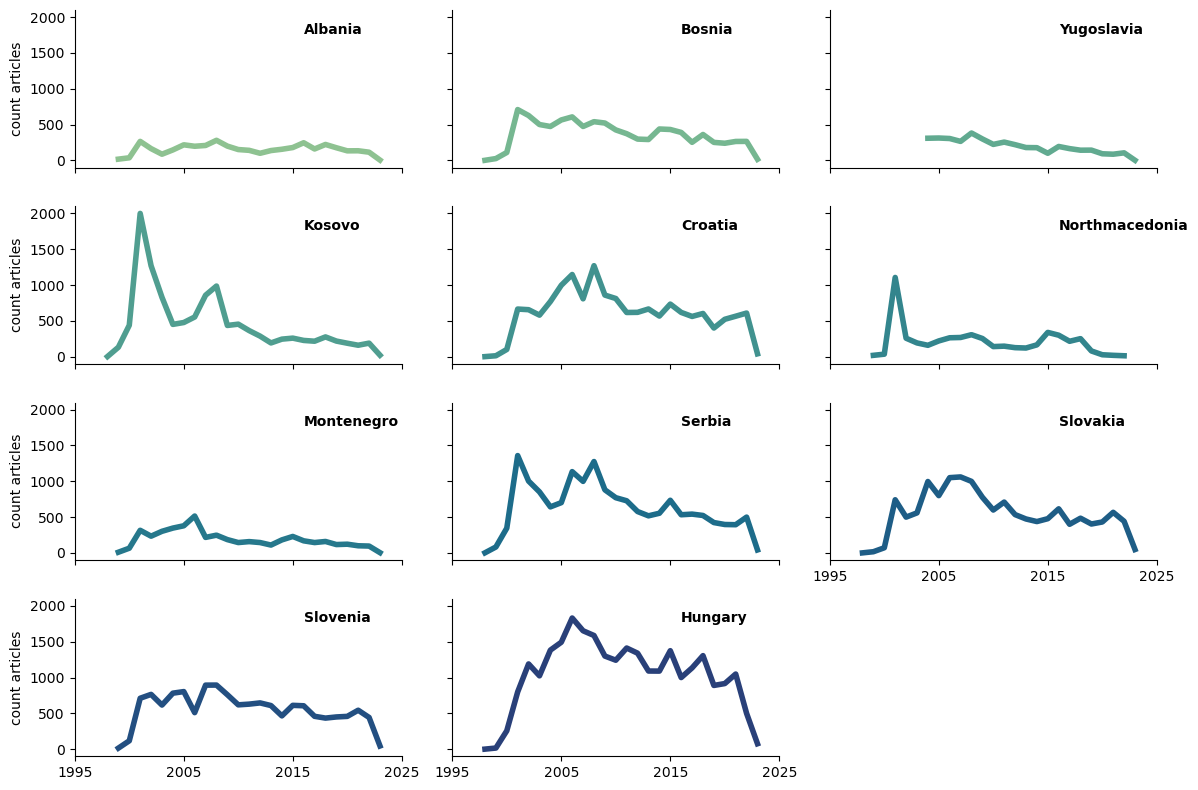

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plt = df.groupby(["country", "year"]).count()[["url"]].reset_index()
df_plt.year = df_plt.year.astype(int)

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_plt,
    x="year",
    y="url",
    col="country",
    hue="country",
    kind="line",
    palette="crest",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=2,
    legend=False,
)

# create a reverse dictionary
countries_min_rev = {val: key for (key, val) in countries_min.items()}

# Iterate over each subplot to customize further
for country, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(
        0.7,
        0.85,
        countries_min_rev[country].capitalize(),
        transform=ax.transAxes,
        fontweight="bold",
    )


# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "count articles")
g.tight_layout()

### Create grouped dataframes

In [78]:
df_grp = (
    df.sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)

df_grp_no_controls = (
    df.loc[~df["country"].isin(["slowakei", "albanien", "ungarn"])]
    .sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)


df_grp["country"] = df_grp["country"].apply(lambda x: "_".join(x))
df_grp_no_controls["country"] = df_grp_no_controls["country"].apply(
    lambda x: "_".join(x)
)

country_count = (
    df_grp.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)
country_count_no_controls = (
    df_grp_no_controls.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)

### Plot treemaps to visualize the proportions of published articles per keyword

In [79]:
def plot_count(cois, country_count, countries_min, threshold=100, alt_title=None):
    """
    Plot for number of articles for a given country.

    - set cois to empty list for all countries

    """

    filter_list = [countries_min[coi] for coi in cois]

    if cois != []:
        country_count = country_count.loc[
            country_count.country.str.contains("|".join(filter_list))
        ].reset_index(drop=True)
        title_country = ", ".join([coi.capitalize() for coi in cois])
    else:
        title_country = "all countries"

    other_sum = country_count.loc[country_count["count"] < threshold, "count"].sum()
    data = (
        country_count.loc[country_count["count"] >= threshold]
        .copy()
        .reset_index(drop=True)
    )

    data.loc[len(data)] = ["other", other_sum]
    data["country"] = data["country"].str.replace("_", "+\n")

    plt.figure(figsize=(12, 9))
    squarify.plot(
        sizes=data["count"],
        label=data["country"],
        alpha=0.7,
        text_kwargs=dict(fontsize=7),
    )

    plt.axis("off")
    if alt_title == None:
        plt.title(
            f"Articles about {title_country} 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )
    else:
        plt.title(
            alt_title
            + f" 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )

#### All scraped articles (incl. control countries)

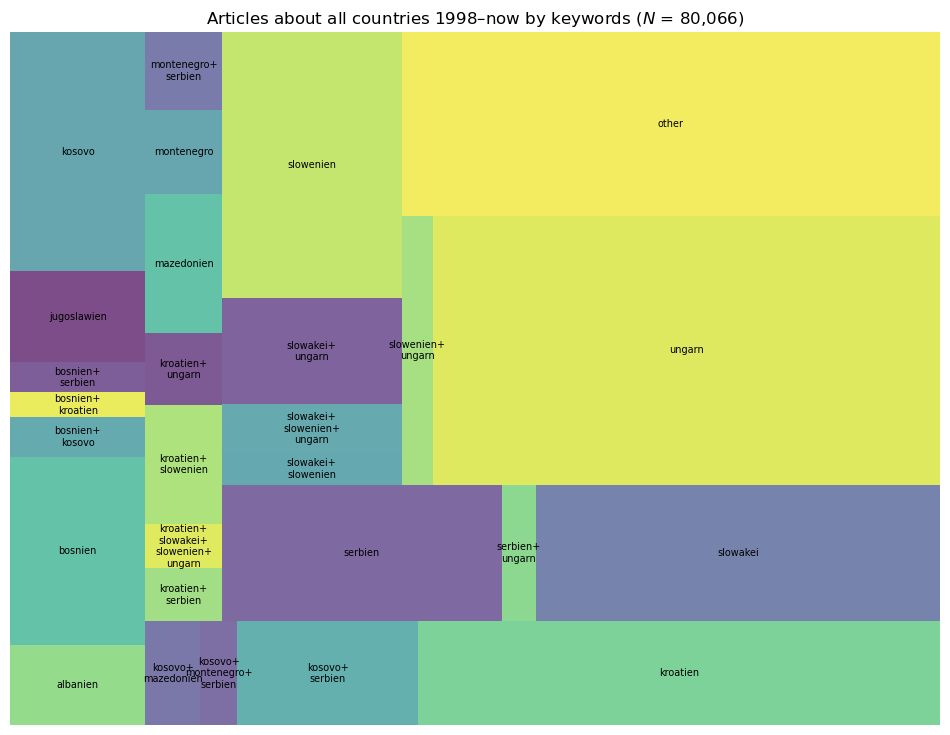

In [80]:
plot_count([], country_count, countries_min, 400)

#### Only articles that includes former Yugoslav countries (and controls removed)

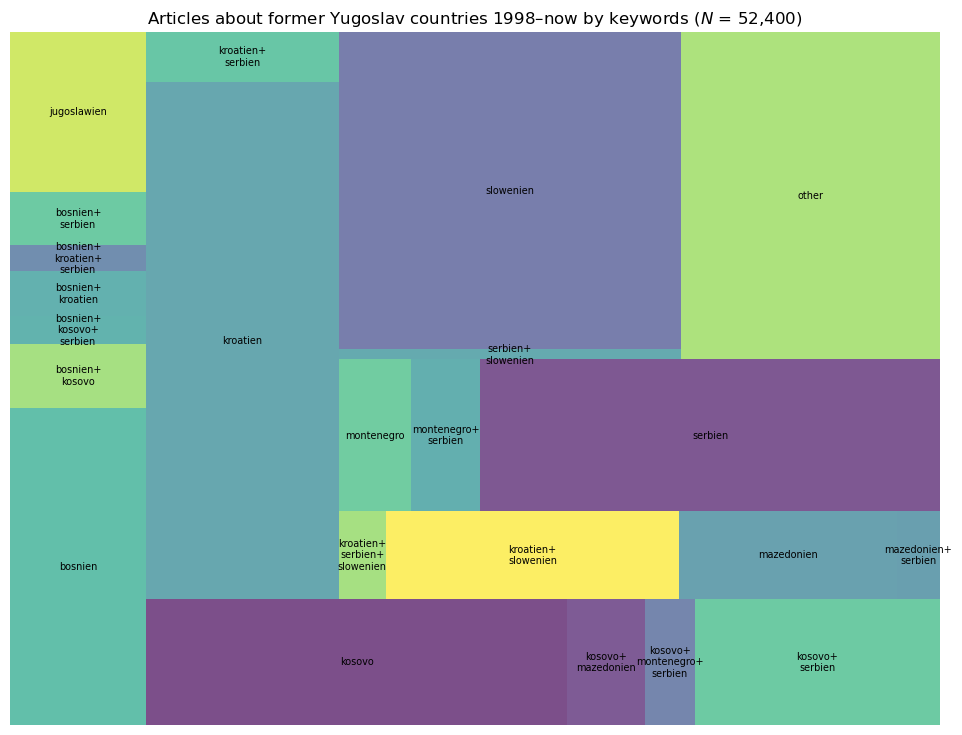

In [81]:
plot_count(
    [
        "yugoslavia",
        "croatia",
        "slovenia",
        "kosovo",
        "bosnia",
        "serbia",
        "montenegro",
        "northmacedonia",
    ],
    country_count_no_controls,
    countries_min,
    250,
    alt_title="Articles about former Yugoslav countries",
)

#### Only articles that include Serbia (controls removed)

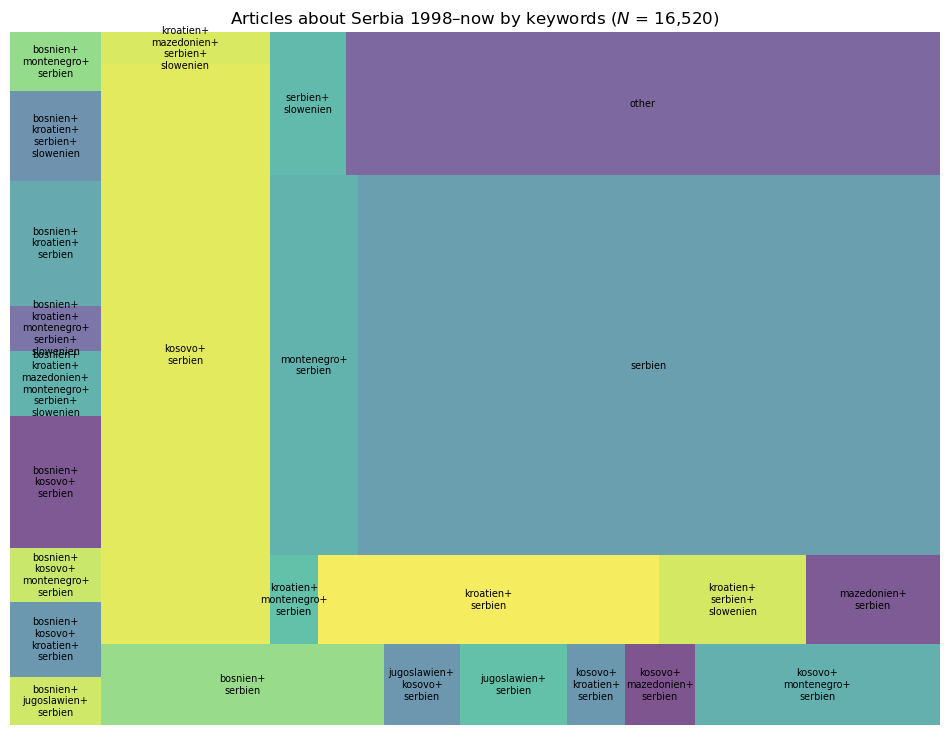

In [82]:
plot_count(["serbia"], country_count_no_controls, countries_min)

#### Only articles that include Croatia (controls removed)

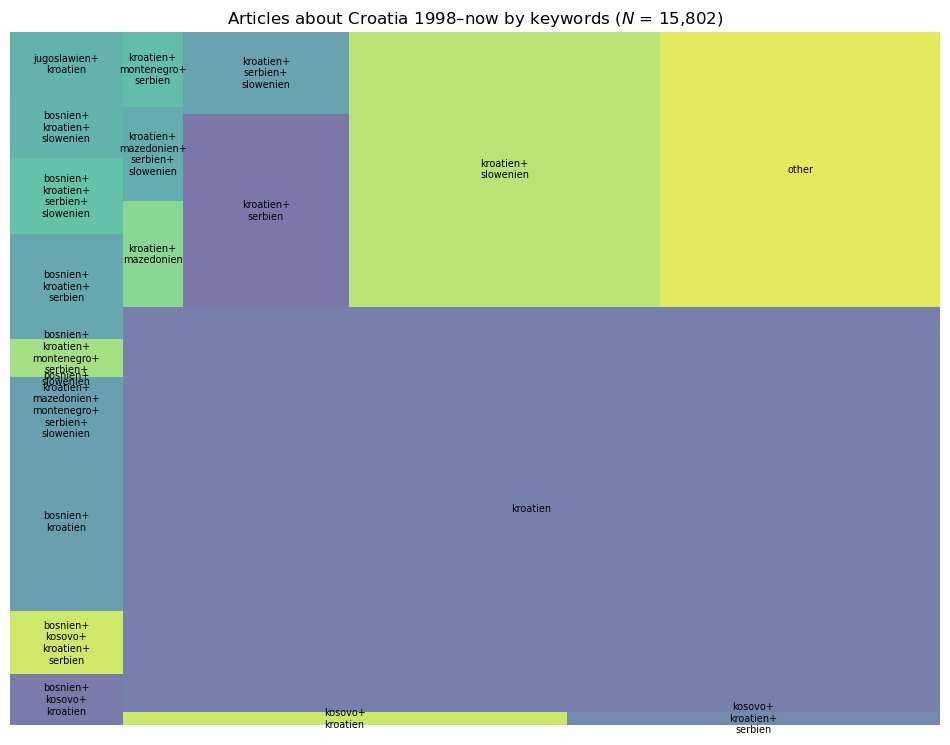

In [83]:
plot_count(["croatia"], country_count_no_controls, countries_min)

## Download

In [ ]:
if os.path.exists(data_dir + "/articles") == False:
    os.makedirs(data_dir + "/articles")


for country in df_grp.country.unique():
    
    
    print("Downloading articles for", country)

    df_country = df_grp.copy().loc[df_grp.country==country]

    for _, row in df_country.iterrows():
        filepath = data_dir + f"/articles/{row.id}.json"
        if os.path.exists(filepath) == False:
            try:
                a_title, a_subtitle, a_text, a_date = get_derstandard_article(row.url)
                with open(filepath, "w") as fp:
                    json.dump(dict(date=a_date, title=a_title, subtitle=a_subtitle, text=a_text), fp)
            except Exception as e:
                print("Problem with url", row.url, e)
        else:
            pass

Problem with url https://www.derstandard.at/story/687170/milosevic-klagt-gegen-haager-tribunalhaft Message: Unable to locate element: time
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:182:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:394:5
element.find/</<@chrome://remote/content/marionette/element.sys.mjs:275:16

Problem with url https://www.derstandard.at/story/708857/jugoslawien-kosovo-albaner-gedenken-der-anschlagsopfer Message: Unable to locate element: time
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:182:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:394:5
element.find/</<@chrome://remote/content/marionette/element.sys.mjs:275:16

Problem with url https://www.derstandard.at/story/1224982/der-groesste-fehler-war-k

## Preprocess text

In [ ]:
def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    output = re.sub(r"[^a-zA-Z0-9]", " ", input)
    return output


def clean_tokenization(input):
    output = nltk.word_tokenize(input)
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [p.number_to_words(item)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization(input):
    output = [lemma.lemmatize(word=w, pos="v") for w in input]
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def preprocessing(text, remove_stopwords=True):
    """
    Preprocessing pipeline.
    """
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization(text)
    text = numbers_to_words(text)
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

In [ ]:
#
#
#

## Sentiment analysis

In [14]:
#
#
#